In [1]:
# Bruno Ugolini
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1 Birth Rates

The data on US births, provided by the CDC is in `data/births.csv`.

Reproduce the following plot of births by gender over time given the data:

![](births_gender.png)

Note the `1e6` on the y axis for scale

Text(0, 0.5, 'total births per year')

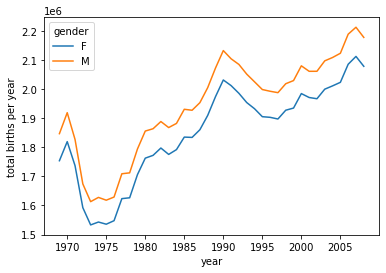

In [2]:
df = pd.read_csv('data/births.csv')
df[df.gender == 'F'].groupby(by='year').sum()['births'].plot(label='F')
df[df.gender == 'M'].groupby(by='year').sum()['births'].plot(label='M')
plt.legend(title='gender')
plt.ylabel('total births per year')

# 1.2 Births anomalies

This was analyzed by beloved statistician Andrew Gelman [here](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/), leading to this plot:

![](births_gp100.png)

Explain all three plots in Gelman's figure. 

**1.2:** What is the periodic component? What is the residual? Use your research skills to learn then explain it (in english).

Top chart:
==========

The black line represents the average number of births per day for a given calendar date presumably collected over many years (1969 to 1988). The data for Feb. 29th was multiplied by 4 to account for leap years.

The "Smoothed" line represents represents a high-order polynomial fit or rolling average to the data in order to remove the higher frequency variations.

The "Mean" represents the mean of the entire dataset ... however, it was normalized to 100 for simplicity. Chris's original chart showed the actual average per the 20-year period.

Middle chart:
=============

This is the attempt to model the periodic (repeated variation with time; oscillatory) of the black line about the smoothed line (from the first chart). The author used three componenets: "2 slowly varying components" (i.e. two long-wavelength cosine series for example) and "a periodic component with decay". This latter is equivalent to a spring-mass-damper system. Example: you hit a speed bump at higher speed than you should. Your car oscillates up and down but the amplitude of that motion decays with time while keeping its sinusodial nature.

Presumably, all of these components + the smoothed line would give you back the black line (see below). And so by this decomposition, an insight is gained into the underlying nature of the data. Let's call this accumulation of curves the "fit".

Bottom chart:
=============

This is the "fit" minus the black curve at the top: the error that cannot be explained by this well-behaved and generally well-fitting model. This chart is used to identify elements that don't fall into the logical modelling of all the other data. The (US) holidays stand out. Because doctors are home with families and don't have time to deliver babies.




# 1.3 Holiday Anomalies Plot

Reproduce *as best you can* the first of the 3 figures from Andrew Gelman's blog post (your plot may have small differences)

**1.3.1:** Reproduce the births line in a plot. Hint: Make the x axis a `pd.datetime` object

**1.3.2:** Reproduce the `smoothed` line. Hint: use a rolling window average

**1.3.3:** Reproduce the entire figure with the mean line as a horizontal. You can make the y axis total births instead of a % deviation from mean axis (they'll look the same anyway)

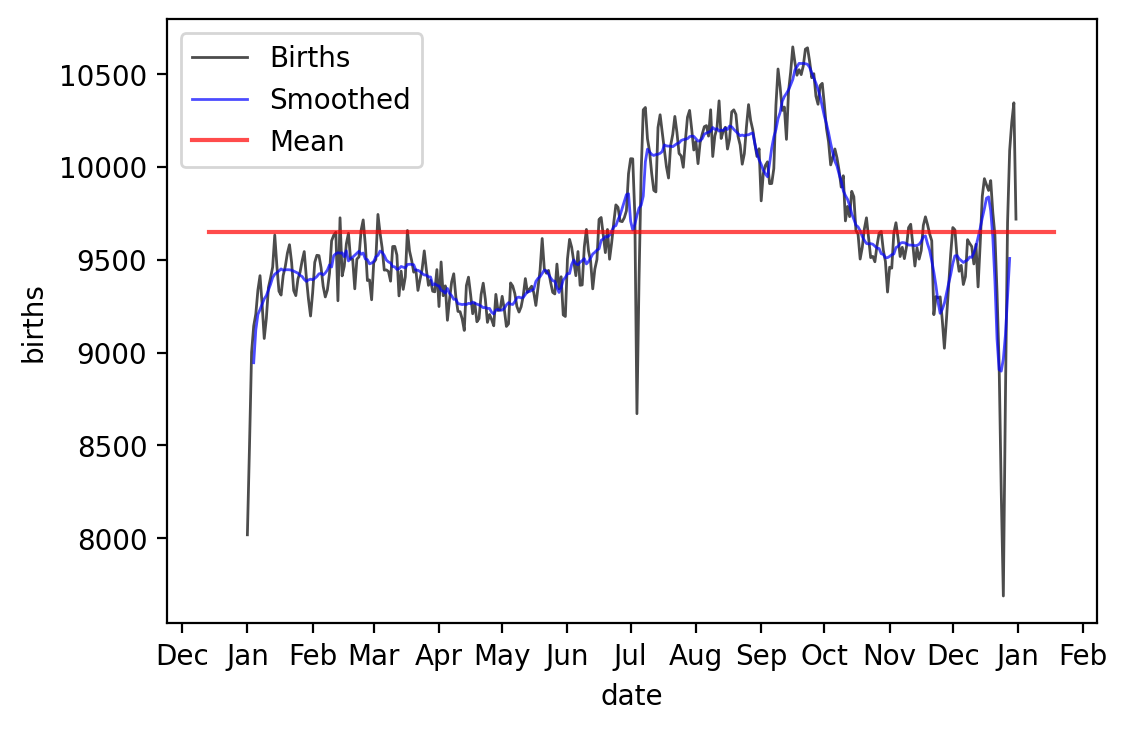

In [6]:
df = pd.read_csv('data/births_q2.csv')
# create a datetime variable
df['year']=2020
#      drop dates that don't make sense
df = df.drop(index=df.loc[(df.month == 2) & (df.day > 29)].index)
df = df.drop(index=df.loc[(df.month.isin([4,6, 9,11])) & (df.day > 30)].index)
#      fix Feb. 29th data
x = df['births'].loc[(df.month==2) & (df.day==29)].index
fix_feb_29 = df.xs(x[0])['births'] * 4
df.xs(x[0])['births'] = fix_feb_29
#  finally create the variable time
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
#  divide births by 20 years
df['births'] = df['births']/20

# clean dataset
df = df.drop(columns=['year','month','day']).set_index('date')

rolling = df.rolling(7, center=True)

# get a rolling average
fig, ax = plt.subplots(dpi=200, figsize=(6,4))
sns.lineplot(data=df,x=df.index,y='births',color='black',lw=1,alpha=0.7,label='Births')
sns.lineplot(data=rolling.mean(),x=rolling.mean().index,y='births',color='blue',lw=1,alpha=0.7,label='Smoothed')
mean_all = df.births.mean()
xmin, xmax = ax.get_xlim()
plt.plot([xmin,xmax],[mean_all,mean_all],color='red',alpha=0.7,label='Mean')

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.dates as mdates
months = mdates.MonthLocator()
month_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(month_fmt)
plt.legend()

# 2. Recipe Database

### 2.1 

Load the JSON recipe database we saw in lecture 4.

How many of the recipes are for breakfast food? Hint: The `description` would contain the work "breakfast"

In [27]:
import gzip
# read the entire file into a Python array
with gzip.open('data/recipe.json.gz', 'r') as f:
    # Extract each line
    data = (line.strip().decode() for line in f)
    # Reformat so each line is the element of a list
    data_json = f"[{','.join(data)}]"
# read the result as a JSON
recipes = pd.read_json(data_json)

In [26]:
#recipes.dropna(subset=['description'], inplace=True)
sum(recipes['description'].str.contains('breakfast').dropna())
# Answer: there are 3442 breakfast recipes

3442

### 2.2 A simple recipe recommender

Let's build a recipe recommender: given a list of basic ingredients, find a recipe that uses all those ingredients.

Here is the list of ingredients that can be asked for:

```
['salt', 'pepper', 'oregano', 'sage', 'parsley',
 'rosemary', 'tarragon', 'thyme', 'paprika', 'cumin']
```

**Hint:** Build a new column for each of the ingredients that indicates whether that ingredient is in the recipe.

**example:**
```
recommend_ingredients(["parsley", "paprika", "tarragon"], df)

result: 
# The rows where these 3 ingredients are in the recipe
[2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175, 165243]
```

In [74]:
recipes['ingredients'].isin(['Biscuits'])
recipes['ingredients'].str.contains('flour', regex=False, case=False)

def recommend_ingredients(ing_lst, df):
    """
    Finds the index of recipes
    which contain all ingredients
    in ing_lst.
    """

    res = df.ingredients.apply(lambda sentence: all(word in sentence for word in ing_lst))
    return df[res].index

In [77]:
res = recommend_ingredients(["parsley", "paprika", "tarragon"], recipes)
res

Int64Index([2069, 74964, 93768, 113926, 137686, 140530, 158475, 158486, 163175,
            165243],
           dtype='int64')

# 3. Movies!

Recall the [Movies Dataset](https://www.kaggle.com/rounakbanik/the-movies-dataset) from lecture 4. It's made up of several tables which we've played with in lecture 4.

The tables have common columns (`id` and `movie_id`) around which you can merge and join tables.

### 3.1 best director

Your task is to find **The best director** in terms of average ratings of his movies. This can be from the `ratings` or `ratings_small` table, or simply the vote average in the `metadata` table. The director can be found in the `cast` table.

You will have to use all of your skills to get this done, between using groupbys and merging multiple tables together